## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segmentation_models_pytorch import utils
from model.data_loader import PneumothoraxDataset
import torchvision.transforms.functional as F

/Users/nikhilhenry/miniconda3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        image = image.detach()
        image = F.to_pil_image(image)
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])


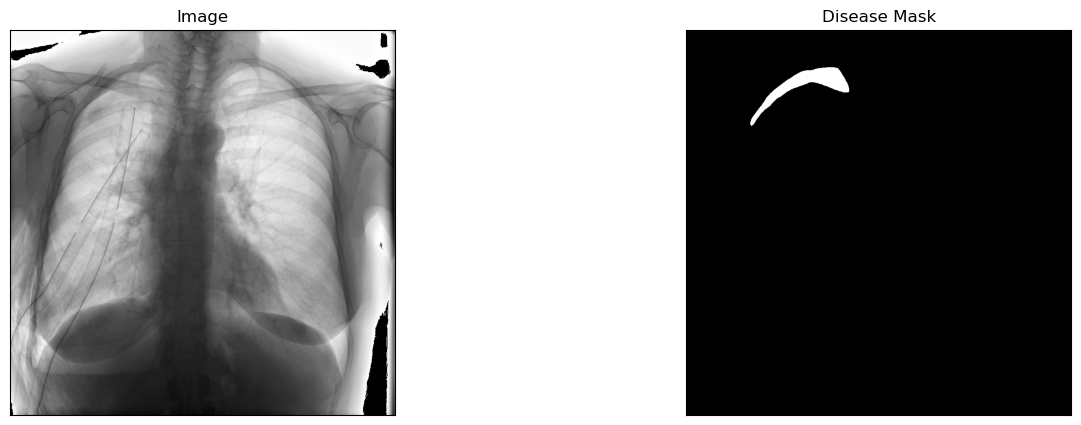

In [5]:
# Lets look at data we have
dataset = PneumothoraxDataset(
    root="data/pneumothorax",
    anotations_file="train-rle.csv",
    img_dir="dicom-images-train-raw",
    mask_dir="dicom-images-train-mask",
)

image, mask = dataset[2] # get some sample
print(image.shape)
print(mask.shape)
visualize(
    image=image, 
    disease_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [6]:
import albumentations as albu

In [7]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=370, min_width=370, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        # albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

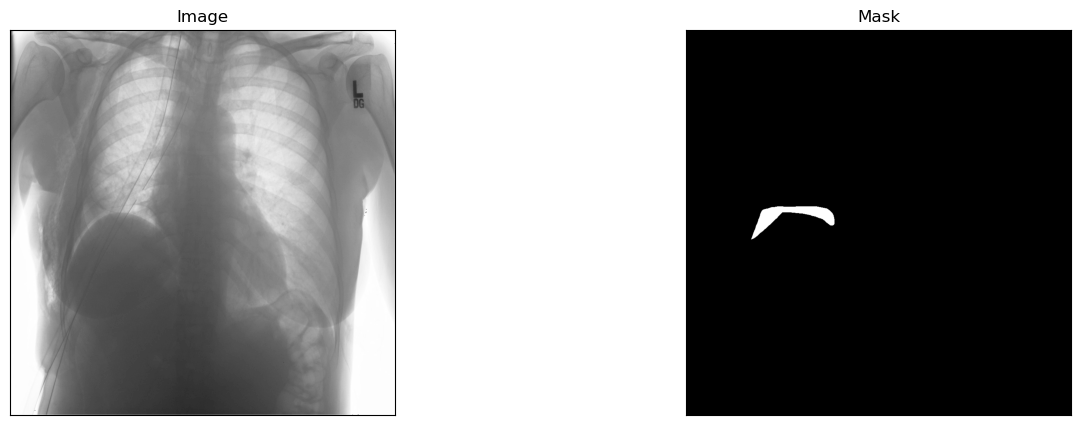

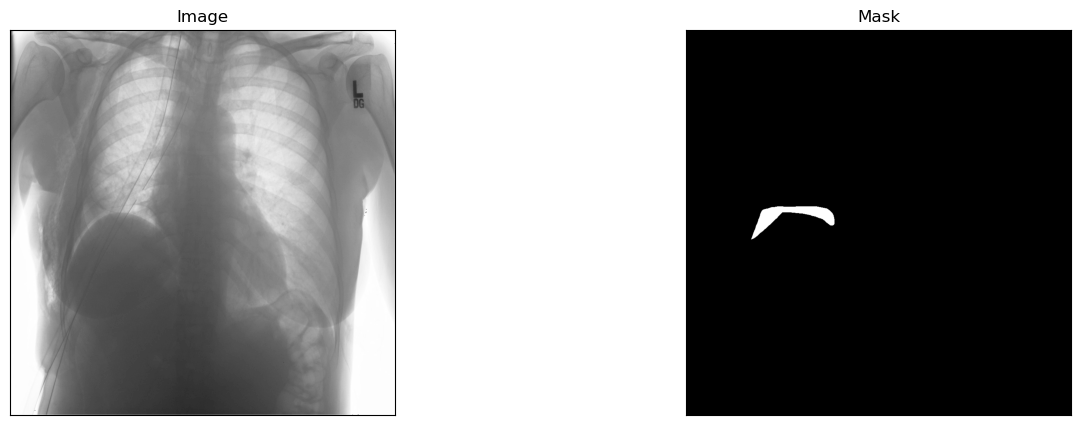

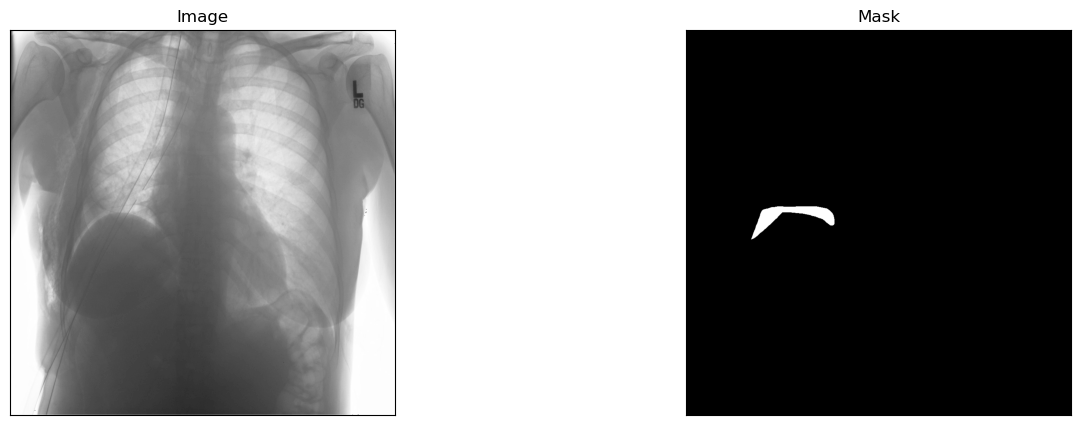

In [8]:
#### Visualize resulted augmented images and masks

augmented_dataset = PneumothoraxDataset(
    root="data/pneumothorax",
    anotations_file="train-rle.csv",
    img_dir="dicom-images-train-raw",
    mask_dir="dicom-images-train-mask",
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [9]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [10]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'mps'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    # classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels=1
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
train_dataset = PneumothoraxDataset(
    root="data/pneumothorax",
    anotations_file="train-rle.csv",
    img_dir="dicom-images-train-raw",
    mask_dir="dicom-images-train-mask",
)

valid_dataset = PneumothoraxDataset(
    root="data/pneumothorax",
    anotations_file="train-rle.csv",
    img_dir="dicom-images-train-raw",
    mask_dir="dicom-images-train-mask",
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [12]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [13]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
# train model for 40 epochs

max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, dice_loss - 2.761, iou_score - 0.007495]
Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s, dice_loss - -50.19, iou_score - 25.55]
Model saved!

Epoch: 2
valid: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, dice_loss - -232.8, iou_score - 16.32]

Epoch: 3
valid: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s, dice_loss - -2.492e+04, iou_score - 15.65]

Epoch: 4
valid: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s, dice_loss - -105.3, iou_score - 8.145]


## Test best saved model

In [15]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [16]:
# create test dataset
test_dataset = PneumothoraxDataset(
    root="data/pneumothorax",
    anotations_file="train-rle.csv",
    img_dir="dicom-images-train-raw",
    mask_dir="dicom-images-train-mask",
)

test_dataloader = DataLoader(test_dataset)

In [17]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:   0%|          | 0/10 [00:00<?, ?it/s]

valid: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s, dice_loss - -50.19, iou_score - 25.55]


## Visualize predictions

In [18]:
# test dataset without transformations for image visualization
valid_dataset = PneumothoraxDataset(
    root="data/pneumothorax",
    anotations_file="train-rle.csv",
    img_dir="dicom-images-train-raw",
    mask_dir="dicom-images-train-mask",
)

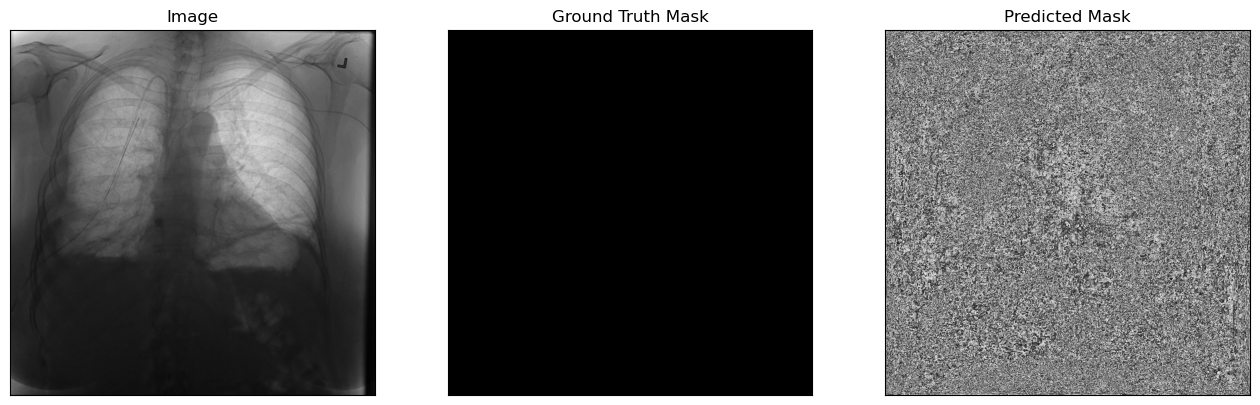

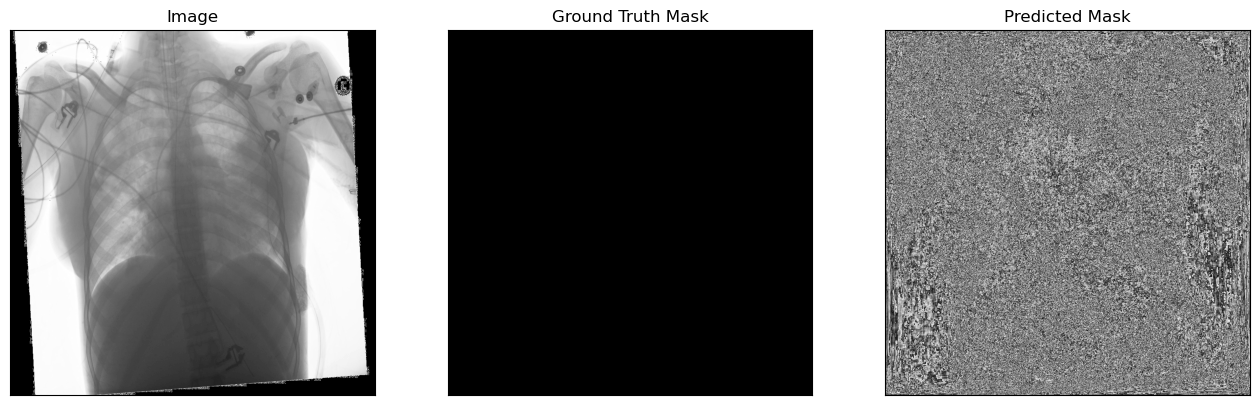

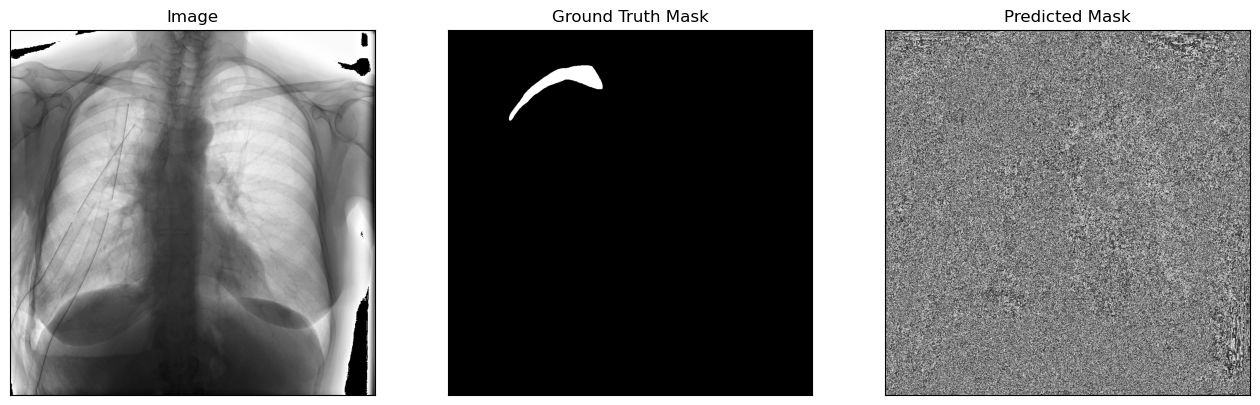

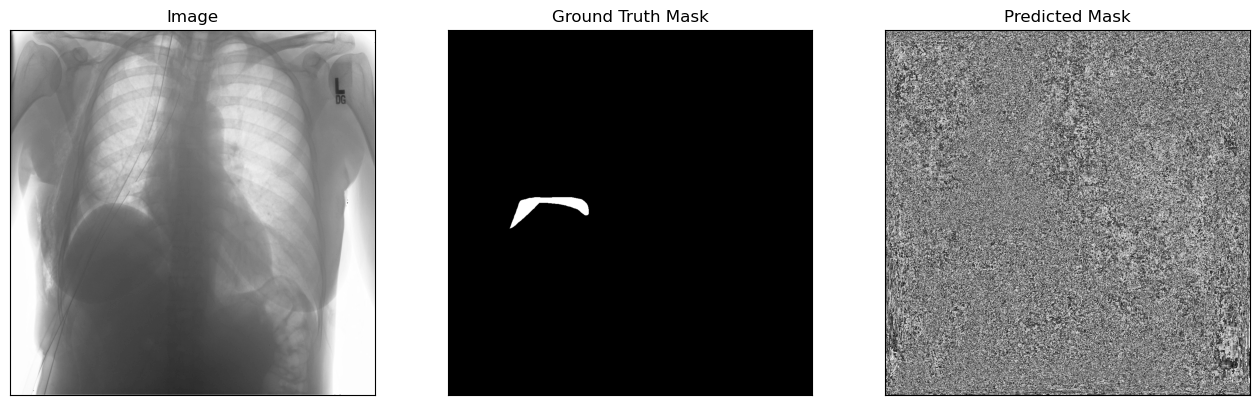

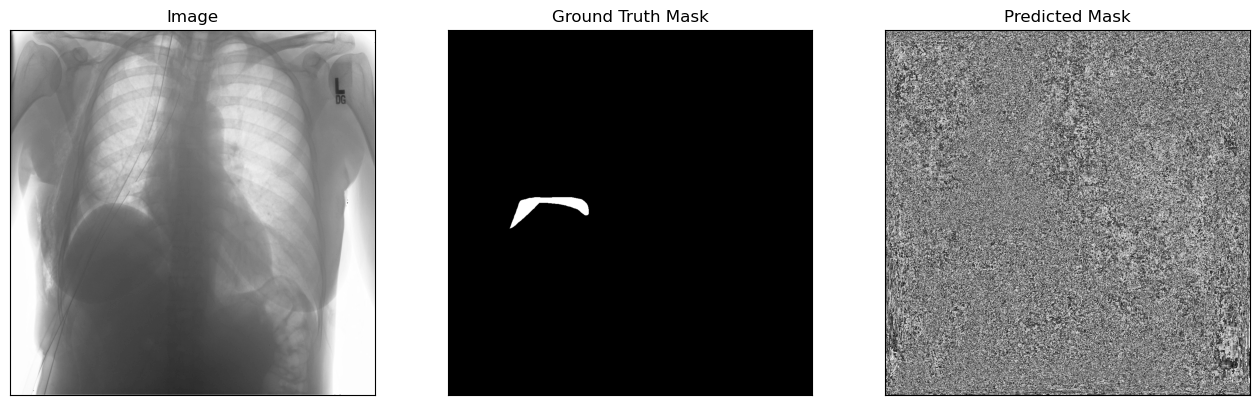

In [19]:
for i in range(5):
    # image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze())
        
    visualize(
        image=image, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [28]:
# create the submission file
from utils.submit import compile_results
predictions = []
for i in range(5):
    image, _ = test_dataset[i]
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze())
    predictions.append(pr_mask)

compile_results(predictions, 'submission.csv')

TypeError: 'module' object is not callable. Did you mean: 'tqdm.tqdm(...)'?